# <center>  On Equivalence of Kalman Filtering Smoothing and Expectation Propagation

In [1]:
import os, sys
# import numpy as np
from functools import partial
import autograd.numpy as np
from autograd import jacobian, grad, primitive
from scipy.stats import multivariate_normal

### <center>                                           Add module paths

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from MomentMatching.StateModels import GaussianState
from MomentMatching.baseMomentMatch import UnscentedTransform, TaylorTransform, MonteCarloTransform
from MomentMatching.auto_grad import logpdf
# from MomentMatching.KalmanFilter import KalmanFilterSmoother

In [3]:
x = np.array([2.0, 0.1])

### <center> Define State Distributions

In [4]:
xx_mean = 1e-5 * np.array([-0.7398, -0.6866], dtype=float)
xx_sigma = np.array([[0.0757,    0.0095],
                     [0.0095,    0.0701]], dtype=float)
state_distribution = GaussianState(xx_mean, xx_sigma)

In [5]:
xx_2_mean = 1e-5 *np.array([-0.3344, 0.1109], dtype=float)
xx_2_sigma =  np.array([[0.0757,    0.0095],
                        [0.0095,    0.0701]], dtype=float)
next_state_distribution = GaussianState(xx_2_mean, xx_2_sigma)

### <center>  Define a linear functions 

In [6]:
A = np.array([[0.2, 0.8],
              [-0.8, 0.4]], dtype=float)

Q = 0.1 * np.eye(2)
R = Q
B = np.array([0.0, 0.0], dtype=float)
Z = A

In [7]:
def measurement_function(x, A=A, B=B):
    return A @ x + B#[:, np.newaxis]

In [8]:
def transition_function(x, A=A, B=B):
    return measurement_function(x, A=A, B=B)

def identity_function(x, A=np.eye(2)):
    return A @ x

### <center> Define Taylor transform TT

In [9]:
TT = TaylorTransform(dimension_of_state=2)

In [10]:
TT.numerical_jacobian(f=measurement_function, x=xx_mean)  # Should be same as A

array([[ 0.2,  0.8],
       [-0.8,  0.4]])

### <center> 

In [11]:
meas_jac = jacobian(transition_function)
meas_jac(xx_mean)  # Should be same as A

array([[ 0.2,  0.8],
       [-0.8,  0.4]])

### <center> Initialise factors

In [12]:
factor_mean = np.array([0.0, 0.0], dtype=float)
factor_sigma = 99999 * np.array([[1, 0], [0, 1]], dtype=float)
measurement_factor = GaussianState(factor_mean, factor_sigma)
measurement = np.array([2.0, 0.0], dtype=float)

In [13]:
fwd_factor_mean = 1.0e-05 * np.array([-0.6972, 0.3172], dtype=float)
fwd_factor_sigma = np.array([[0.1509,   0.0050],
                             [0.0050,   0.1536]], dtype=float)
fwd_factor = GaussianState(fwd_factor_mean, fwd_factor_sigma)

### <center> Define Likelihood for EP updates

In [14]:
def data_likelihood(f, mean, cov, measurement ):
    
    meanz = f(mean)   # z = f(x)
    linear_C = jacobian(f)(mean)  # linear factor A 
    covz = linear_C @ cov @ linear_C.T #  predictive covariance sz = var(f(x)) = A * Sigma * A^T
    logZi = logpdf(measurement, meanz, covz)
    return logZi

In [15]:
def data_likelihood2(f, mean1, cov1, mean2, cov2, Q= Q):
    
    meanx = f(mean1)   # z = f(x))
    linear_C = jacobian(f)(mean1)  # linear factor A 
    covx = linear_C @ cov1 @ linear_C.T + Q #  predictive covariance sz = var(f(x)) = A * Sigma * A^T
    logZi = logpdf(mean2, meanx, covx + cov2)
    return logZi

In [16]:
def moment_matching(cavity_distribution, dlogZidMz, dlogZidSz):
    
    mx = cavity_distribution.mean + np.dot(cavity_distribution.cov, dlogZidMz.T)
    vx = cavity_distribution.cov - cavity_distribution.cov @  (  np.outer(dlogZidMz, dlogZidMz) - 2*dlogZidSz ) @ cavity_distribution.cov.T  

    return GaussianState(mx, vx)

##############################################################################################################

# <center>  Measurement Update

##############################################################################################################

In [17]:
def ep_measurement_update( measurement_function, state_distribution,  z_measurement):
    
    #form cavity
    measurement_cavity = state_distribution / measurement_factor
    
    # logZi and it's derivatives
    logZi = data_likelihood(measurement_function, measurement_cavity.mean, measurement_cavity.cov, measurement)
    dlogZidMz = jacobian(data_likelihood, argnum=1)(measurement_function, measurement_cavity.mean, measurement_cavity.cov, z_measurement)
    dlogZidSz = jacobian(data_likelihood, argnum=2)(measurement_function, measurement_cavity.mean, measurement_cavity.cov, z_measurement)
    

    filtered_distribution = moment_matching(measurement_cavity, dlogZidMz, dlogZidSz)
    
    return filtered_distribution
    

In [18]:
EP_measurement_update = ep_measurement_update(measurement_function, state_distribution, measurement)

#### <center> Kalman Filter Measurement update

In [19]:
def measurement_update(self, measurement_function, state_distribution, z_measurement):

    z_mean, z_cov, xz_cross_cov = self.predict(measurement_function, state_distribution)
    # Add measurement Noise R_t
    z_cov = z_cov #+ self.system_model.R.cov

    K = np.matmul(xz_cross_cov, np.linalg.inv(z_cov))

    corrected_mean = state_distribution.mean + np.dot(K, (z_measurement - z_mean))  # equation 15  in Marc's ACC paper
    corrected_cov = state_distribution.cov - np.dot(K, np.transpose(xz_cross_cov))

    filtered_distribution = GaussianState(corrected_mean, corrected_cov)
    return filtered_distribution

In [20]:
Kalman_measurement_update = measurement_update(TT, measurement_function, state_distribution, measurement)

####  <center>  Check whether EP and Kalman filter are equal

In [21]:
EP_measurement_update == Kalman_measurement_update

True

In [22]:
EP_measurement_update 

GaussianState 
 mean=
 [ 1.11111111  2.22222222], 
 cov=
[[  2.35922393e-16   2.65412692e-16]
 [  5.60315683e-16   9.43689571e-16]])

In [23]:
Kalman_measurement_update

GaussianState 
 mean=
 [ 1.11111111  2.22222222], 
 cov=
[[  1.38777878e-17  -1.73472348e-18]
 [ -1.73472348e-18  -1.38777878e-17]])

##############################################################################################################

# <center> Smoothing Update

##############################################################################################################

#### <center> Kalman smoother the RTS version

In [24]:
def Kalman_smoother(self, transition_function, x_distribution, x_next_distribution, Q=Q):
    # Forward pre1diction
    xx_mean, xx_cov, xx_cross_cov, = self.predict(transition_function, x_distribution)
    
    # Add transition Noise Q_t
    xx_cov = xx_cov + Q

    # calculate smoother gain J_t
    J = np.matmul(xx_cross_cov, np.linalg.inv(xx_cov))

    smoothed_mean = x_distribution.mean + np.dot(J, (x_next_distribution.mean - xx_mean))
    smoothed_cov = x_distribution.cov + J @ (x_next_distribution.cov - xx_cov) @ J.T
    smoothed_distribution = GaussianState(smoothed_mean, smoothed_cov)
    return smoothed_distribution

In [25]:
Kalman_smoother_update = Kalman_smoother(TT, transition_function, state_distribution, next_state_distribution)

#### <center> EP update with derivatives

In [26]:
def ep_back_update( transition_function, state_distribution,  next_state_distribution, back_factor, fwd_factor, Q=Q ):    
    
    # Form cavity distribution
    back_cavity = state_distribution / back_factor
    fwd_cavity = next_state_distribution / fwd_factor
    
    # Moment matching 
    arg_tuple = (transition_function, back_cavity.mean, back_cavity.cov, fwd_cavity.mean, fwd_cavity.cov, Q)
    logZi = data_likelihood2 (*arg_tuple)  
    dlogZidMz = jacobian(data_likelihood2, argnum=1)(*arg_tuple)  
    dlogZidSz = jacobian(data_likelihood2, argnum=2)(*arg_tuple)

    EP_smoother = moment_matching(back_cavity, dlogZidMz, dlogZidSz)
    
    return EP_smoother

In [27]:
EP_back_update = ep_back_update(transition_function, state_distribution, next_state_distribution, measurement_factor, fwd_factor)

 ####  <center>  Check if EP and Kalman smoother are equal 

In [28]:
Kalman_smoother_update == EP_back_update  

True

In [29]:
EP_back_update

GaussianState 
 mean=
 [ -6.03291231e-06  -5.73561091e-06], 
 cov=
[[ 0.06141629  0.00806166]
 [ 0.00806166  0.05842577]])

In [30]:
Kalman_smoother_update

GaussianState 
 mean=
 [ -6.03289547e-06  -5.73569883e-06], 
 cov=
[[ 0.06141654  0.00806106]
 [ 0.00806106  0.05842459]])

In [1]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
x = np.sin(range(15))

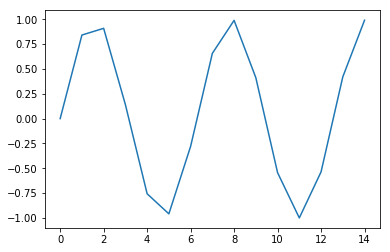

In [6]:
plt.plot(x)